<a href="https://colab.research.google.com/drive/1tymTIsZdVkL4bCeowoCj0kFLX9REzUHe?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from scipy import stats
import sklearn.linear_model as skl
import sklearn.metrics as skm
from seaborn import heatmap
from sklearn.decomposition import PCA
import copy
from sklearn import svm

fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
fname = "resnet50_features.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ALYbVzD8Irznxx8BA65DnrcM09Tg5KgJ' -O resnet50_features.npy --quiet
fname = "resnet50_test_features.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1a1uwmP7oD7P_iHWmHRXKQq6o08b5DWpA' -O resnet50_test_features.npy --quiet

fname = "vgg16_features.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1epaylkWvcX0D-escbA9Yjj6WdJ3-SDcZ' -O vgg16_features.npy --quiet
fname = "vgg16_test_features.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WrY7hmGtVQRPcefUwCJUf1NyosG-EfMy' -O vgg16_test_features.npy --quiet

fname = "vgg16_convfeatures.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10r8jd5ql6e1HxuO-y_w7cbya7MJohtcF' -O vgg16_convfeatures.npy --quiet
fname = "vgg16_test_convfeatures.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_lbObrQt733e03yHAF3pADfsj6PuCLQ2' -O vgg16_test_convfeatures.npy --quiet

In [ ]:
dataset = 'v'

if dataset == 'r':

  X_train = dat['responses']
  X_test = dat['responses_test']
  y_train = np.load('/content/resnet50_features.npy') 
  y_test = np.load('/content/resnet50_test_features.npy') 

  feats = 'Resnet50'

elif dataset == 'v':

  X_train = dat['responses']
  X_test = dat['responses_test']
  y_train = np.load('/content/vgg16_features.npy') 
  y_test = np.load('/content/vgg16_test_features.npy') 

  feats = 'VGG16'

elif dataset == 'vc':

  X_train = dat['responses']
  X_test = dat['responses_test']
  y_train = np.load('/content/vgg16_convfeatures.npy', allow_pickle=True) 
  y_test = np.load('/content/vgg16_test_convfeatures.npy', allow_pickle=True) 

  feats = 'VGG16 Convolution Layer'
  
print(feats, 'selected:')
print('\t X_train.shape: ', X_train.shape)
print('\t y_train.shape: ', y_train.shape)
print('\t X_test.shape:  ', X_test.shape)
print('\t y_test.shape:  ', y_test.shape)

print('Test set statistics:')
print('\t Mean:\t', np.mean(y_test))
print('\t Std:\t', np.std(y_test))
print('\t Range:\t', np.max(y_test)-np.min(y_test))

VGG16 selected:
	 X_train.shape:  (1750, 8428)
	 y_train.shape:  (1750, 4096)
	 X_test.shape:   (120, 8428)
	 y_test.shape:   (120, 4096)
Test set statistics:
	 Mean:	 0.18907653
	 Std:	 0.3137314
	 Range:	 3.2452157


# Each ROI to features

## Unbalanced ROIs

In [ ]:
num_alphas = 10

score_vec = np.zeros(shape=(np.max(dat['roi']) +1, num_alphas))
test_mse_vec = np.zeros(shape=(np.max(dat['roi']) +1, num_alphas))

alphas = np.logspace(0,6,num=num_alphas)

for roi in range(1, np.max(dat['roi']) +1):

  if roi != 0:
  
    print('Training with full ROI', roi, 'named', dat['roi_names'][roi], '...')

    X_train_loop = X_train[:, dat['roi'] == roi]
    X_test_loop  = X_test[:, dat['roi'] == roi]

    print('\t X_train_loop.shape: ', X_train_loop.shape)
    print('\t X_test_loop.shape:  ', X_test_loop.shape)

    mse_train_vec = np.zeros_like(alphas)
    mse_test_vec = np.zeros_like(alphas)

    models_vec = []

    progress = copy.copy(num_alphas)

    for a in alphas:
      print('\t\t', progress, 'alphas remaining')

      model = skl.Ridge(alpha=a)

      model.fit(X_train_loop, y_train)

      y_hat_Train = model.predict(X_train_loop)
      mse_train = np.mean((y_train-y_hat_Train)**2)
      mse_train_vec[a == alphas] = mse_train

      y_hat_Test = model.predict(X_test_loop)
      mse_test = np.mean((y_test-y_hat_Test)**2)
      mse_test_vec[a == alphas] = mse_test
      
      models_vec.append(model)

      score_vec[roi, alphas == a] = skm.r2_score(y_test, y_hat_Test)
      test_mse_vec[roi, alphas == a] = skm.mean_squared_error(y_test, y_hat_Test)

      progress -= 1

score_vec = score_vec[1:, :]
test_mse_vec = test_mse_vec[1:, :]

Training with full ROI 1 named V1 ...
	 X_train_loop.shape:  (1750, 1294)
	 X_test_loop.shape:   (120, 1294)
		 10 alphas remaining
		 9 alphas remaining
		 8 alphas remaining
		 7 alphas remaining
		 6 alphas remaining
		 5 alphas remaining
		 4 alphas remaining
		 3 alphas remaining
		 2 alphas remaining
		 1 alphas remaining
Training with full ROI 2 named V2 ...
	 X_train_loop.shape:  (1750, 2083)
	 X_test_loop.shape:   (120, 2083)
		 10 alphas remaining
		 9 alphas remaining
		 8 alphas remaining
		 7 alphas remaining
		 6 alphas remaining
		 5 alphas remaining
		 4 alphas remaining
		 3 alphas remaining
		 2 alphas remaining
		 1 alphas remaining
Training with full ROI 3 named V3 ...
	 X_train_loop.shape:  (1750, 1790)
	 X_test_loop.shape:   (120, 1790)
		 10 alphas remaining
		 9 alphas remaining
		 8 alphas remaining
		 7 alphas remaining
		 6 alphas remaining
		 5 alphas remaining
		 4 alphas remaining
		 3 alphas remaining
		 2 alphas remaining
		 1 alphas remaining
Training w

Text(0.5, 1.0, 'Test Mean-Squared Errors, full ROIs, mapped to VGG16')

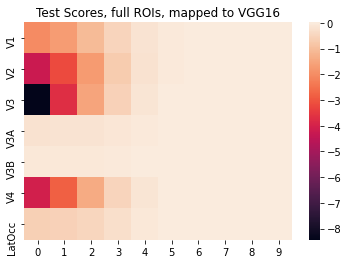

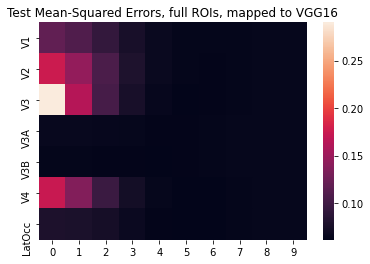

In [ ]:
plt.figure()
heatmap(score_vec, yticklabels=dat['roi_names'][1:])
plt.title('Test Scores, full ROIs, mapped to ' + feats)

plt.figure()
heatmap(test_mse_vec, yticklabels=dat['roi_names'][1:])
plt.title('Test Mean-Squared Errors, full ROIs, mapped to ' + feats)

Text(0.5, 1.0, 'Test Mean-Squared Errors, all voxels per ROI, mapped to VGG16')

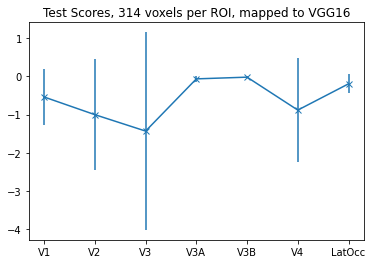

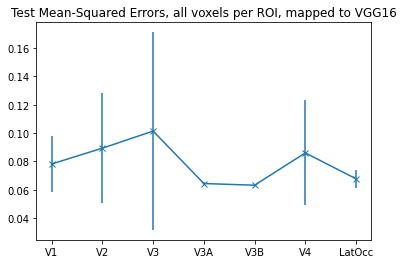

In [ ]:
plt.figure()
plt.errorbar(range(1,8), score_vec.mean(1), yerr = score_vec.std(1), fmt='x-')
plt.xticks(ticks=range(1,8), labels=dat['roi_names'][1:])
plt.title('Test Scores, 314 voxels per ROI, mapped to ' + feats)

plt.figure()
plt.errorbar(range(1,8), test_mse_vec.mean(1), yerr = test_mse_vec.std(1), fmt='x-')
plt.xticks(ticks=range(1,8), labels=dat['roi_names'][1:])
plt.title('Test Mean-Squared Errors, all voxels per ROI, mapped to ' + feats)

## Balanced to 314 ROIs

In [ ]:
num_alphas = 10
num_runs = 15

indices = np.arange(len(dat['roi']))

score_vec = np.zeros(shape=(np.max(dat['roi']) +1, num_alphas, num_runs))
test_mse_vec = np.zeros(shape=(np.max(dat['roi']) +1, num_alphas, num_runs))

alphas = np.logspace(0,3,num=num_alphas)

for roi in range(1, np.max(dat['roi']) +1):

  if roi != 0:

    for k in range(num_runs):
  
      print(k ,') Training with 314 voxels/ROI', roi, 'named', dat['roi_names'][roi], '...')

      idx = np.random.choice(indices[dat['roi'] == roi], 314 )

      X_train_loop = X_train[:, idx]
      X_test_loop  = X_test[:, idx]

      print('\t X_train_loop.shape: ', X_train_loop.shape)
      print('\t X_test_loop.shape:  ', X_test_loop.shape)

      mse_train_vec = np.zeros_like(alphas)
      mse_test_vec = np.zeros_like(alphas)

      models_vec = []

      progress = copy.copy(num_alphas)

      print('\t Testing different alphas...')

      for a in alphas:
        print('\t\t', progress, 'alphas remaining')

        model = skl.Ridge(alpha=a)

        model.fit(X_train_loop, y_train)

        y_hat_Train = model.predict(X_train_loop)
        mse_train = np.mean((y_train-y_hat_Train)**2)
        mse_train_vec[a == alphas] = mse_train

        y_hat_Test = model.predict(X_test_loop)
        mse_test = np.mean((y_test-y_hat_Test)**2)
        mse_test_vec[a == alphas] = mse_test
        
        models_vec.append(model)

        score_vec[roi, alphas == a, k] = skm.r2_score(y_test, y_hat_Test)
        test_mse_vec[roi, alphas == a, k] = skm.mean_squared_error(y_test, y_hat_Test)

        progress -= 1

0 ) Training with 314 voxels/ROI 1 named V1 ...
	 X_train_loop.shape:  (1750, 314)
	 X_test_loop.shape:   (120, 314)
	 Testing different alphas...
		 10 alphas remaining
		 9 alphas remaining
		 8 alphas remaining
		 7 alphas remaining
		 6 alphas remaining
		 5 alphas remaining
		 4 alphas remaining
		 3 alphas remaining
		 2 alphas remaining
		 1 alphas remaining
1 ) Training with 314 voxels/ROI 1 named V1 ...
	 X_train_loop.shape:  (1750, 314)
	 X_test_loop.shape:   (120, 314)
	 Testing different alphas...
		 10 alphas remaining
		 9 alphas remaining
		 8 alphas remaining
		 7 alphas remaining
		 6 alphas remaining
		 5 alphas remaining
		 4 alphas remaining
		 3 alphas remaining
		 2 alphas remaining
		 1 alphas remaining
2 ) Training with 314 voxels/ROI 1 named V1 ...
	 X_train_loop.shape:  (1750, 314)
	 X_test_loop.shape:   (120, 314)
	 Testing different alphas...
		 10 alphas remaining
		 9 alphas remaining
		 8 alphas remaining
		 7 alphas remaining
		 6 alphas remaining
		 5 a

Text(0.5, 1.0, 'Test MSEs, 314 voxels per ROI, mapped to VGG16')

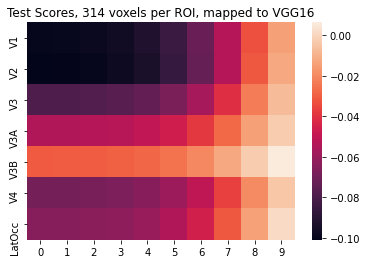

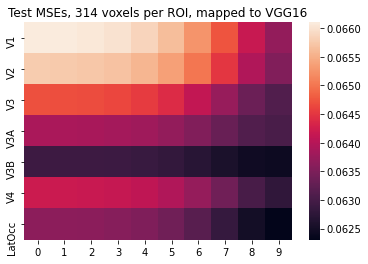

In [ ]:
# score_vec = score_vec[1:, :, :].mean(2)
# test_mse_vec = test_mse_vec[1:, :, :].mean(2)

plt.figure()
heatmap(score_vec[1:, :, :].mean(2), yticklabels=dat['roi_names'][1:])
plt.title('Test Scores, 314 voxels per ROI, mapped to ' + feats)

plt.figure()
heatmap(test_mse_vec[1:, :, :].mean(2), yticklabels=dat['roi_names'][1:])
plt.title('Test MSEs, 314 voxels per ROI, mapped to ' + feats)

Text(0.5, 1.0, 'Test MSEs, 314 voxels per ROI, mapped to VGG16')

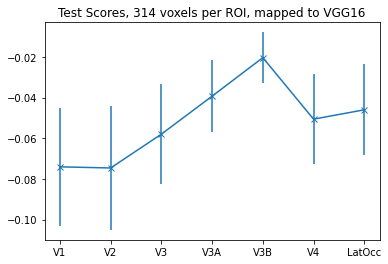

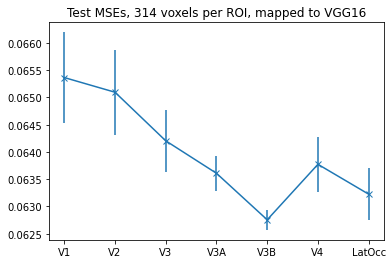

In [ ]:
plt.figure()
plt.errorbar(range(1,8), score_vec[1:, :, :].mean(2).mean(1), yerr = score_vec[1:, :, :].mean(2).std(1), fmt='x-')
plt.xticks(ticks=range(1,8), labels=dat['roi_names'][1:])
plt.title('Test Scores, 314 voxels per ROI, mapped to ' + feats)

plt.figure()
plt.errorbar(range(1,8), test_mse_vec[1:, :, :].mean(2).mean(1), yerr = test_mse_vec[1:, :, :].mean(2).std(1), fmt='x-')
plt.xticks(ticks=range(1,8), labels=dat['roi_names'][1:])
plt.title('Test set MSEs, 314 voxels per ROI, mapped to ' + feats)

# What do the weights look like on ROI's?

## Unbalanced

In [ ]:
print('Fitting GLM to', feats, 'with Ridge...')

num_alphas = 10

alphas = np.logspace(0,6,num=num_alphas)

mse_train_vec = np.zeros_like(alphas)
mse_test_vec = np.zeros_like(alphas)

models_vec = []

progress = copy.copy(num_alphas)

for a in alphas:
  print('\t', progress, 'alphas remaining')

  model = skl.Ridge(alpha=a)

  model.fit(X_train, y_train)

  y_hat_Train = model.predict(X_train)
  mse_train = np.mean((y_train-y_hat_Train)**2)
  mse_train_vec[a == alphas] = mse_train

  y_hat_Test = model.predict(X_test)
  mse_test = np.mean((y_test-y_hat_Test)**2)
  mse_test_vec[a == alphas] = mse_test
  
  models_vec.append(model)

  progress -= 1

Fitting GLM to VGG16 with Ridge...
	 10 alphas remaining
	 9 alphas remaining
	 8 alphas remaining
	 7 alphas remaining
	 6 alphas remaining
	 5 alphas remaining
	 4 alphas remaining
	 3 alphas remaining
	 2 alphas remaining
	 1 alphas remaining


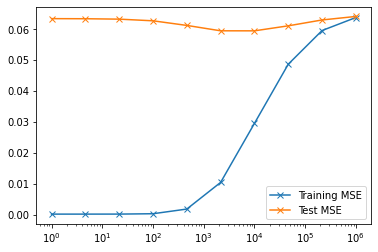

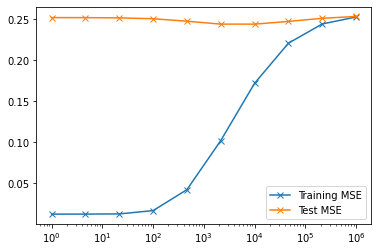

In [ ]:
plt.figure()
plt.plot(alphas, mse_train_vec, 'x-', label='Training MSE')
plt.plot(alphas, mse_test_vec, 'x-', label='Test MSE')
plt.xscale('log')
plt.legend()
# plt.yscale('log')

plt.figure()
plt.plot(alphas, np.sqrt(mse_train_vec), 'x-', label='Training MSE')
plt.plot(alphas, np.sqrt(mse_test_vec), 'x-', label='Test MSE')
plt.xscale('log')
plt.legend()
# plt.yscale('log')

In [ ]:
coefs = []

for l in range(len(models_vec)):
  coefs.append(models_vec[l].coef_)

coefs = np.array(coefs).mean(0)

roi_coef_squared = np.zeros_like(dat['roi_names'])[1:]

for roi in range(1,np.max(dat['roi'])+1):
  roi_coef_squared[roi-1] = (coefs[:, dat['roi']==roi]**2).mean()

Text(0.5, 1.0, 'Average of the squared weights per ROI, using VGG16')

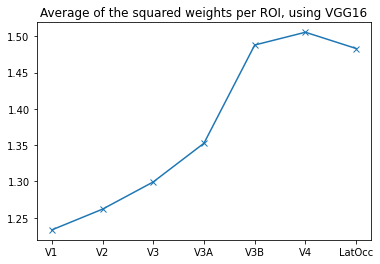

In [ ]:
plt.figure()
plt.plot(range(1,8), roi_coef_squared.astype(float), 'x-')
plt.xticks(ticks=range(1,8), labels=dat['roi_names'][1:])
plt.title('Average of the squared weights per ROI, using ' + feats)

## 314 voxel per ROI

In [ ]:
print('Fitting GLM to', feats, 'with Ridge...')

num_alphas = 10
num_runs = 10

alphas = np.logspace(0,6,num=num_alphas)

coefs = np.zeros(shape=(np.max(dat['roi'])+1, num_alphas, num_runs))

models_vec = []

progress = copy.copy(num_alphas)

for k in range(num_runs):

  mse_train_vec = np.zeros_like(alphas)
  mse_test_vec = np.zeros_like(alphas)

  idx = np.arange(X_test.shape[1])

  X_new_train = np.empty(shape=(1750,0))
  X_new_test  = np.empty(shape=(120,0))

  new_rois = np.empty(shape=(0,))

  for roi in range(np.max(dat['roi'])+1):
    if roi != 0:
      indices = np.random.choice(idx[ dat['roi']==roi ].astype(int), 314)

      X_new_train = np.hstack((X_new_train, X_train[:, indices])) 
      X_new_test = np.hstack((X_new_test, X_test[:, indices]))

      new_rois = np.append(new_rois, roi * np.ones_like(indices))

  print(feats, 'selected:')
  print('\t X_new_train.shape: ', X_new_train.shape)
  print('\t y_train.shape:     ', y_train.shape)
  print('\t X_new_test.shape:  ', X_new_test.shape)
  print('\t y_test.shape:      ', y_test.shape)

  for a in alphas:
    print('\t', progress, 'alphas remaining')

    model = skl.Ridge(alpha=a)

    model.fit(X_new_train, y_train)

    y_hat_Train = model.predict(X_new_train)
    mse_train = np.mean((y_train-y_hat_Train)**2)
    mse_train_vec[a == alphas] = mse_train

    y_hat_Test = model.predict(X_new_test)
    mse_test = np.mean((y_test-y_hat_Test)**2)
    mse_test_vec[a == alphas] = mse_test
    
    models_vec.append(model)

    progress -= 1

  model = models_vec

Fitting GLM to VGG16 with Ridge...
VGG16 selected:
	 X_new_train.shape:  (1750, 2198)
	 y_train.shape:      (1750, 4096)
	 X_new_test.shape:   (120, 2198)
	 y_test.shape:       (120, 4096)
	 10 alphas remaining
	 9 alphas remaining
	 8 alphas remaining
	 7 alphas remaining
	 6 alphas remaining
	 5 alphas remaining
	 4 alphas remaining
	 3 alphas remaining
	 2 alphas remaining
	 1 alphas remaining
VGG16 selected:
	 X_new_train.shape:  (1750, 2198)
	 y_train.shape:      (1750, 4096)
	 X_new_test.shape:   (120, 2198)
	 y_test.shape:       (120, 4096)
	 0 alphas remaining
	 -1 alphas remaining
	 -2 alphas remaining
	 -3 alphas remaining
	 -4 alphas remaining
	 -5 alphas remaining
	 -6 alphas remaining
	 -7 alphas remaining
	 -8 alphas remaining
	 -9 alphas remaining
VGG16 selected:
	 X_new_train.shape:  (1750, 2198)
	 y_train.shape:      (1750, 4096)
	 X_new_test.shape:   (120, 2198)
	 y_test.shape:       (120, 4096)
	 -10 alphas remaining
	 -11 alphas remaining
	 -12 alphas remaining
	 -1

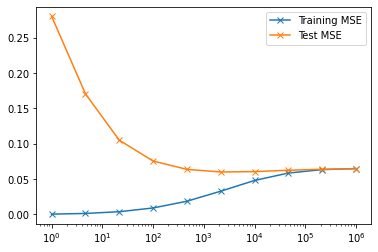

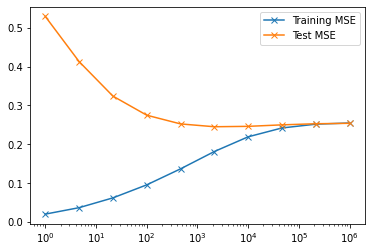

In [ ]:
plt.figure()
plt.plot(alphas, mse_train_vec, 'x-', label='Training MSE')
plt.plot(alphas, mse_test_vec, 'x-', label='Test MSE')
plt.xscale('log')
plt.legend()
# plt.yscale('log')

plt.figure()
plt.plot(alphas, np.sqrt(mse_train_vec), 'x-', label='Training MSE')
plt.plot(alphas, np.sqrt(mse_test_vec), 'x-', label='Test MSE')
plt.xscale('log')
plt.legend()
# plt.yscale('log')